In [62]:
import numpy as np
from keras.layers import Layer, Concatenate, Input, Dense, Multiply, Add, RepeatVector, Lambda, BatchNormalization, Dropout, LayerNormalization
import keras.backend as K
from keras.models import load_model, Model
from keras.metrics import CategoricalAccuracy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
from keras.losses import CategoricalCrossentropy, MeanSquaredError
from keras.optimizers import Adam, Adadelta, Adagrad, Adamax
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay, ExponentialDecay
import json
from sklearn.model_selection import train_test_split

In [63]:
model_dir = 'model'
tanh_layer_size = 512
q_input_size = 768
i_input_size = 512
output_size = 2327
regions = 15

In [64]:
class QGAttention(Layer):
    def __init__(self, tanh_layer_size):
        super(QGAttention, self).__init__()
        self.tanh_layer_size = tanh_layer_size
 
    def build(self,input_shape):
        self.W1 = self.add_weight(name='attention_weight', shape=(input_shape[0][2], self.tanh_layer_size), 
                               initializer='random_normal', trainable=True)
        self.W2 = self.add_weight(name='attention_weight2', shape=(self.tanh_layer_size, 1), 
                               initializer='random_normal', trainable=True)
        super(QGAttention, self).build(input_shape)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "tanh_layer_size": self.tanh_layer_size,
        })
        return config
    
    # x = [batch_size, vector_length, regions]
    def call(self,input):
        x = input[0]
        regions = input[1]
        #tanh layer
        e = K.tanh(K.dot(x, self.W1))
        #linear layer
        #print('e: ', e)
        e = K.dot(e, self.W2)
        #print('e: ', e)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        #print('e: ', e)
        # Compute the weights
        alpha = K.softmax(e)
        #print('alpha: ', alpha)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        #print('alpha: ', alpha)
        # Compute the context vector
        context = regions * alpha
        #print('context: ', context)
        context = K.sum(context, axis=1)
        #print('context: ', context)
        return context

In [65]:
# https://visualqa.org/static/img/equation.png
def vqa_metric_single(y_true, y_pred):
    max_index = y_pred.index(max(y_pred))
    pred = [1 if i == max_index else 0 for i, _ in enumerate(y_pred)]
    times_answered = y_true.count(pred)
    score = min(times_answered/3, 1)
    return score

def vqa_metric(y_true, y_pred):
    scores = []
    for i, _ in enumerate(y_pred):
        scores.append(vqa_metric_single(y_true[i], y_pred[i].tolist()))
    return sum(scores) / len(scores)

In [73]:
@tf.function
def cond(inp):
    x = inp[0]
    y = inp[1]
    return tf.cond(tf.math.count_nonzero(x) == 0, lambda: tf.zeros(tf.shape(y)), lambda: tf.ones(tf.shape(y)))

def get_model(max_regions, q_input_size, r_input_size, tanh_layer_size):
    # output = 15x512
    r_inputs = Input(shape=(max_regions, r_input_size))
    # output = 768
    q_inputs = Input(shape=(q_input_size))
    # output = 15x768
    q_repeated_without_zeros = RepeatVector(max_regions)(q_inputs)
    # output = 15x768
    q_repeated_inputs = Lambda(cond)((r_inputs, q_repeated_without_zeros))
    # output = 15x1280
    attn_inputs = Concatenate()([r_inputs, q_repeated_inputs])
    # output = 512
    weighted_regions = QGAttention(tanh_layer_size)([attn_inputs, r_inputs])
    # output = 512
    tanh_question = Dense(512, activation='tanh')(q_inputs)
    # output = 512
    tanh_regions = Dense(512, activation='tanh')(weighted_regions)
    # output = 512
    region_question = Multiply()([tanh_question, tanh_regions])
    # output = 512
    region_nonlinear = Dense(512, activation='tanh')(region_question)
    # output = 768
    question_nonlinear = Dense(768, activation='tanh')(region_question)
    # output = 2327
    region_linear = Dense(2327)(region_nonlinear)
    # output = 2327
    question_linear = Dense(2327)(question_nonlinear)
    # output = 2327
    region_question_sum = Add()([region_linear, question_linear])
    # output = 2327
    dropout = Dropout(0.67)(region_question_sum)
    # output = 2327
    outputs = Dense(2327, activation='sigmoid')(dropout)

    model = Model(inputs=[r_inputs, q_inputs], outputs=outputs)
    
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=0.01,
#         decay_steps=500,
#         decay_rate=0.5
#     )

#     lr_schedule = PiecewiseConstantDecay([500, 1000, 20000], [0.01, 0.005, 0.001, 0.00001])
    
    model.compile(
        optimizer=Adadelta(), 
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    return model

In [74]:
def train(x_train, y_train, x_val, y_val):
    model = get_model(regions, q_input_size, i_input_size, tanh_layer_size)
    print(model.summary())
    
    es = EarlyStopping(monitor='val_categorical_accuracy', 
                       mode='max', 
#                        min_delta=0.5, 
                       patience=50)
    mc = ModelCheckpoint('model/best_model.h5', 
                         monitor='val_categorical_accuracy', 
                         mode='max', 
                         save_best_only=True,
                         save_weights_only=True)
    
    history = model.fit(x_train, y_train, 
                        verbose=2, 
                        validation_data=(x_val, y_val), 
                        epochs=1000, 
                        callbacks=[es, mc],
                        batch_size=100
                       )
    try:
        model.load_weights('model/best_model.h5')
        _, old_acc = evaluate(x_val, y_val)
        _, new_acc = model.evaluate(x_val, y_val)
        if new_acc > old_acc:
            model.save(model_dir)
    except Exception:
        model.save(model_dir)
    return history

In [75]:
def predict(x, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.predict(x)

In [76]:
def evaluate(x, y, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.evaluate(x, y)

In [77]:
def get_image_regions(string):
    result = str2fvs(string)
    result = result[:regions]
    current_len = len(result)
    for _ in range(0, regions-current_len):
        result.append([0]*i_input_size)
    return result

def str2fvs(string):
    fvs = []
    for strfv in string.split('#'):
        fv = []
        for v in strfv.split('|'):
            fv.append(float(v))
        fvs.append(fv)
    return fvs

def str2fv(string):
    fv = []
    for v in string.split('|'):
        fv.append(float(v))
    return fv

In [78]:
def build_model_input(df):
    image_regions = []
    questions = []
    answers = []
    for row in df.values:
        question = row[0]
        img_regions = row[2]
        answer = row[4:]
        image_regions.append(get_image_regions(img_regions))
        questions.append(str2fv(question))
        answers.append(answer)
        
    return [tf.convert_to_tensor(image_regions), tf.convert_to_tensor(questions)], tf.convert_to_tensor(answers)

def train_val_split(df):
    train, val = train_test_split(df, test_size=0.1, random_state=42)
    train.to_csv('data/train2.csv', index=False)
    val.to_csv('data/val.csv', index=False)

In [79]:
train_df = pd.read_csv('data/train2.csv')
# train_val_split(df)
val_df = pd.read_csv('data/val.csv')
x_train, y_train = build_model_input(train_df)
x_val, y_val = build_model_input(val_df)

In [80]:
history = train(x_train, y_train, x_val, y_val)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 15, 512)]    0           []                               
                                                                                                  
 repeat_vector_6 (RepeatVector)  (None, 15, 768)     0           ['input_14[0][0]']               
                                                                                                  
 lambda_6 (Lambda)              (None, 15, 768)      0           ['input_13[0][0]',               
                                                                  'repeat_vector_6[0][0]']  

Epoch 28/1000
51/51 - 3s - loss: 10.1573 - categorical_accuracy: 0.0998 - val_loss: 9.5914 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 29/1000
51/51 - 3s - loss: 10.1458 - categorical_accuracy: 0.0994 - val_loss: 9.5481 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 30/1000
51/51 - 3s - loss: 10.1239 - categorical_accuracy: 0.0962 - val_loss: 9.5104 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 31/1000
51/51 - 3s - loss: 10.0774 - categorical_accuracy: 0.0980 - val_loss: 9.4770 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 32/1000
51/51 - 3s - loss: 10.0673 - categorical_accuracy: 0.0954 - val_loss: 9.4473 - val_categorical_accuracy: 0.0996 - 3s/epoch - 57ms/step
Epoch 33/1000
51/51 - 3s - loss: 10.0406 - categorical_accuracy: 0.0960 - val_loss: 9.4213 - val_categorical_accuracy: 0.0996 - 3s/epoch - 60ms/step
Epoch 34/1000
51/51 - 3s - loss: 10.0221 - categorical_accuracy: 0.0996 - val_loss: 9.3971 - val_categoric

Epoch 84/1000
51/51 - 3s - loss: 9.5849 - categorical_accuracy: 0.1002 - val_loss: 8.8860 - val_categorical_accuracy: 0.1192 - 3s/epoch - 58ms/step
Epoch 85/1000
51/51 - 3s - loss: 9.5740 - categorical_accuracy: 0.1017 - val_loss: 8.8783 - val_categorical_accuracy: 0.1192 - 3s/epoch - 57ms/step
Epoch 86/1000
51/51 - 3s - loss: 9.5515 - categorical_accuracy: 0.0978 - val_loss: 8.8736 - val_categorical_accuracy: 0.1192 - 3s/epoch - 57ms/step
Epoch 87/1000
51/51 - 3s - loss: 9.5415 - categorical_accuracy: 0.1013 - val_loss: 8.8670 - val_categorical_accuracy: 0.1157 - 3s/epoch - 57ms/step
Epoch 88/1000
51/51 - 3s - loss: 9.5397 - categorical_accuracy: 0.1059 - val_loss: 8.8605 - val_categorical_accuracy: 0.1157 - 3s/epoch - 57ms/step
Epoch 89/1000
51/51 - 3s - loss: 9.5411 - categorical_accuracy: 0.1015 - val_loss: 8.8550 - val_categorical_accuracy: 0.1157 - 3s/epoch - 57ms/step
Epoch 90/1000
51/51 - 3s - loss: 9.5365 - categorical_accuracy: 0.0940 - val_loss: 8.8495 - val_categorical_accu

51/51 - 3s - loss: 9.2151 - categorical_accuracy: 0.1188 - val_loss: 8.5971 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 140/1000
51/51 - 3s - loss: 9.2264 - categorical_accuracy: 0.1269 - val_loss: 8.5949 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 141/1000
51/51 - 3s - loss: 9.2244 - categorical_accuracy: 0.1235 - val_loss: 8.5914 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 142/1000
51/51 - 3s - loss: 9.2113 - categorical_accuracy: 0.1219 - val_loss: 8.5880 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 143/1000
51/51 - 3s - loss: 9.1987 - categorical_accuracy: 0.1223 - val_loss: 8.5831 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 144/1000
51/51 - 3s - loss: 9.1865 - categorical_accuracy: 0.1207 - val_loss: 8.5801 - val_categorical_accuracy: 0.1263 - 3s/epoch - 57ms/step
Epoch 145/1000
51/51 - 3s - loss: 9.2068 - categorical_accuracy: 0.1202 - val_loss: 8.5749 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 9.0154 - categorical_accuracy: 0.1411 - val_loss: 8.4312 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 195/1000
51/51 - 3s - loss: 8.9894 - categorical_accuracy: 0.1399 - val_loss: 8.4286 - val_categorical_accuracy: 0.1406 - 3s/epoch - 58ms/step
Epoch 196/1000
51/51 - 3s - loss: 8.9834 - categorical_accuracy: 0.1386 - val_loss: 8.4279 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 197/1000
51/51 - 3s - loss: 8.9700 - categorical_accuracy: 0.1447 - val_loss: 8.4263 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 198/1000
51/51 - 3s - loss: 9.0113 - categorical_accuracy: 0.1435 - val_loss: 8.4222 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 199/1000
51/51 - 3s - loss: 9.0019 - categorical_accuracy: 0.1390 - val_loss: 8.4206 - val_categorical_accuracy: 0.1388 - 3s/epoch - 57ms/step
Epoch 200/1000
51/51 - 3s - loss: 8.9854 - categorical_accuracy: 0.1388 - val_loss: 8.4189 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 8.8977 - categorical_accuracy: 0.1526 - val_loss: 8.3634 - val_categorical_accuracy: 0.1637 - 3s/epoch - 57ms/step
Epoch 250/1000
51/51 - 3s - loss: 8.8859 - categorical_accuracy: 0.1552 - val_loss: 8.3658 - val_categorical_accuracy: 0.1637 - 3s/epoch - 56ms/step
Epoch 251/1000
51/51 - 3s - loss: 8.9282 - categorical_accuracy: 0.1506 - val_loss: 8.3638 - val_categorical_accuracy: 0.1655 - 3s/epoch - 57ms/step
Epoch 252/1000
51/51 - 3s - loss: 8.8622 - categorical_accuracy: 0.1586 - val_loss: 8.3644 - val_categorical_accuracy: 0.1655 - 3s/epoch - 56ms/step
Epoch 253/1000
51/51 - 3s - loss: 8.8811 - categorical_accuracy: 0.1570 - val_loss: 8.3647 - val_categorical_accuracy: 0.1655 - 3s/epoch - 56ms/step
Epoch 254/1000
51/51 - 3s - loss: 8.8732 - categorical_accuracy: 0.1554 - val_loss: 8.3644 - val_categorical_accuracy: 0.1673 - 3s/epoch - 57ms/step
Epoch 255/1000
51/51 - 3s - loss: 8.9178 - categorical_accuracy: 0.1601 - val_loss: 8.3594 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 8.8474 - categorical_accuracy: 0.1758 - val_loss: 8.3908 - val_categorical_accuracy: 0.1779 - 3s/epoch - 58ms/step
Epoch 305/1000
51/51 - 3s - loss: 8.8629 - categorical_accuracy: 0.1714 - val_loss: 8.3899 - val_categorical_accuracy: 0.1815 - 3s/epoch - 58ms/step
Epoch 306/1000
51/51 - 3s - loss: 8.9042 - categorical_accuracy: 0.1655 - val_loss: 8.3900 - val_categorical_accuracy: 0.1815 - 3s/epoch - 59ms/step
Epoch 307/1000
51/51 - 3s - loss: 8.8856 - categorical_accuracy: 0.1726 - val_loss: 8.3901 - val_categorical_accuracy: 0.1815 - 3s/epoch - 60ms/step
Epoch 308/1000
51/51 - 3s - loss: 8.8909 - categorical_accuracy: 0.1696 - val_loss: 8.3920 - val_categorical_accuracy: 0.1851 - 3s/epoch - 59ms/step
Epoch 309/1000
51/51 - 3s - loss: 8.8664 - categorical_accuracy: 0.1690 - val_loss: 8.3937 - val_categorical_accuracy: 0.1815 - 3s/epoch - 57ms/step
Epoch 310/1000
51/51 - 3s - loss: 8.8674 - categorical_accuracy: 0.1744 - val_loss: 8.3960 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 8.9511 - categorical_accuracy: 0.1819 - val_loss: 8.4875 - val_categorical_accuracy: 0.1975 - 3s/epoch - 60ms/step
Epoch 360/1000
51/51 - 3s - loss: 8.9184 - categorical_accuracy: 0.1781 - val_loss: 8.4919 - val_categorical_accuracy: 0.1975 - 3s/epoch - 61ms/step
Epoch 361/1000
51/51 - 3s - loss: 8.9613 - categorical_accuracy: 0.1750 - val_loss: 8.4890 - val_categorical_accuracy: 0.1975 - 3s/epoch - 59ms/step
Epoch 362/1000
51/51 - 3s - loss: 8.9503 - categorical_accuracy: 0.1809 - val_loss: 8.4902 - val_categorical_accuracy: 0.1993 - 3s/epoch - 58ms/step
Epoch 363/1000
51/51 - 3s - loss: 8.9513 - categorical_accuracy: 0.1779 - val_loss: 8.4925 - val_categorical_accuracy: 0.1975 - 3s/epoch - 60ms/step
Epoch 364/1000
51/51 - 3s - loss: 8.9281 - categorical_accuracy: 0.1825 - val_loss: 8.4970 - val_categorical_accuracy: 0.1975 - 3s/epoch - 58ms/step
Epoch 365/1000
51/51 - 3s - loss: 8.9563 - categorical_accuracy: 0.1892 - val_loss: 8.4980 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 9.1116 - categorical_accuracy: 0.1811 - val_loss: 8.6441 - val_categorical_accuracy: 0.2028 - 3s/epoch - 57ms/step
Epoch 415/1000
51/51 - 3s - loss: 9.0738 - categorical_accuracy: 0.1849 - val_loss: 8.6533 - val_categorical_accuracy: 0.2046 - 3s/epoch - 57ms/step
Epoch 416/1000
51/51 - 3s - loss: 9.1130 - categorical_accuracy: 0.1908 - val_loss: 8.6582 - val_categorical_accuracy: 0.2046 - 3s/epoch - 57ms/step
Epoch 417/1000
51/51 - 3s - loss: 9.1247 - categorical_accuracy: 0.1851 - val_loss: 8.6657 - val_categorical_accuracy: 0.2046 - 3s/epoch - 59ms/step
Epoch 418/1000
51/51 - 3s - loss: 9.1054 - categorical_accuracy: 0.1886 - val_loss: 8.6706 - val_categorical_accuracy: 0.2046 - 3s/epoch - 59ms/step
Epoch 419/1000
51/51 - 3s - loss: 9.1151 - categorical_accuracy: 0.1946 - val_loss: 8.6719 - val_categorical_accuracy: 0.2046 - 3s/epoch - 58ms/step
Epoch 420/1000
51/51 - 3s - loss: 9.1217 - categorical_accuracy: 0.1855 - val_loss: 8.6765 - val_categorical_accuracy: 0.

51/51 - 3s - loss: 9.3553 - categorical_accuracy: 0.1892 - val_loss: 8.8922 - val_categorical_accuracy: 0.2064 - 3s/epoch - 57ms/step
Epoch 470/1000
51/51 - 3s - loss: 9.3803 - categorical_accuracy: 0.1873 - val_loss: 8.8941 - val_categorical_accuracy: 0.2028 - 3s/epoch - 57ms/step
Epoch 471/1000
51/51 - 3s - loss: 9.3996 - categorical_accuracy: 0.1944 - val_loss: 8.8972 - val_categorical_accuracy: 0.2028 - 3s/epoch - 57ms/step
Epoch 472/1000
51/51 - 3s - loss: 9.3498 - categorical_accuracy: 0.1918 - val_loss: 8.9077 - val_categorical_accuracy: 0.2046 - 3s/epoch - 57ms/step
Epoch 473/1000
51/51 - 3s - loss: 9.3443 - categorical_accuracy: 0.1898 - val_loss: 8.9182 - val_categorical_accuracy: 0.1993 - 3s/epoch - 57ms/step
Epoch 474/1000
51/51 - 3s - loss: 9.3822 - categorical_accuracy: 0.1855 - val_loss: 8.9225 - val_categorical_accuracy: 0.1993 - 3s/epoch - 57ms/step
INFO:tensorflow:Assets written to: model/assets


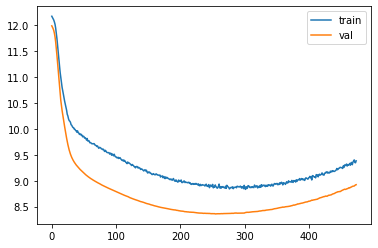

In [81]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

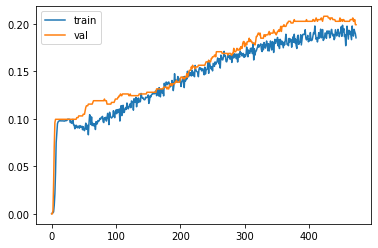

In [82]:
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [83]:
def build_dict():
    df = pd.read_csv('data/test.csv')
    dict_df = pd.DataFrame()
    answers = []
    indices = []
    for column in df.columns:
        answers.append(column)
        indices.append(df.columns.get_loc(column)-4)
    dict_df['answer'] = answers[4:]
    dict_df['index'] = indices[4:]
    dict_df.to_csv('data/dict.csv', index=False)

In [84]:
_, accuracy = evaluate(x_train, y_train, model_dir)
accuracy

158/158 [==============================] - 1s 8ms/step - loss: 8.5557 - categorical_accuracy: 0.2452


0.245249405503273

In [85]:
test_df = pd.read_csv('data/test.csv')
dict_df = pd.read_csv('data/dict.csv')
f = open('data/train_original.json', "r")
answers_file = json.load(f)
f.close()

## NUMBERS

In [86]:
number_df = test_df[test_df.answer_type == 'number']
print(number_df.shape[0])

ty = []
for row in number_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(number_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

5
1/1 [==============================] - 0s 69ms/step
VQA metric - 0.06666666666666667
1/1 [==============================] - 0s 95ms/step - loss: 9.5234 - categorical_accuracy: 0.2000
Accuracy - 0.20000000298023224


## YES/NO

In [87]:
yesno_df = test_df[test_df.answer_type == 'yes/no']
print(yesno_df.shape[0])

ty = []
for row in yesno_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(yesno_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

49
2/2 [==============================] - 0s 7ms/step
VQA metric - 0.5782312925170069
2/2 [==============================] - 0s 8ms/step - loss: 2.2444 - categorical_accuracy: 0.4490
Accuracy - 0.44897958636283875


## OTHER

In [88]:
other_df = test_df[test_df.answer_type == 'other']
print(other_df.shape[0])

ty = []
for row in other_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(other_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

568
18/18 [==============================] - 0s 8ms/step
VQA metric - 0.2646713615023475
18/18 [==============================] - 0s 8ms/step - loss: 6.0286 - categorical_accuracy: 0.1884
Accuracy - 0.18838028609752655


## TOTAL

In [89]:
ty = []
for row in test_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(test_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

20/20 [==============================] - 0s 8ms/step
VQA metric - 0.2889957264957266
20/20 [==============================] - 0s 8ms/step - loss: 5.7463 - categorical_accuracy: 0.2083
Accuracy - 0.2083333283662796
